There are two main benefits to using transfer learning:

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

In [1]:
import tensorflow as tf

# Setup gpu drivers
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-07-09 03:40:31.991213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 03:40:32.875382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-09 03:40:34.181014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-09 03:40:34.199597: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-07-09 03:40:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4004:801::2010, 2800:3f0:4004:805::2010, 2800:3f0:4004:806::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2800:3f0:4004:801::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160,74M  21,8MB/s    in 8,2s    

2023-07-09 03:40:42 (19,5 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks

In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

### Creating models using TensorFlow Hub

- ResNetV2 - a state of the art computer vision model architecture from 2016.
- EfficientNet - a state of the art computer vision architecture from 2019.

In [6]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [8]:
def create_model(model_url, num_classes=10):
    """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in output layer, should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes outputs.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False, # freeze the underlying patterns
        name='feature_extraction_layer',
        input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer, # use the feature extraction layer as the base
        layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
    ])

    return model

In [9]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

In [10]:
# Fit the model
resnet_history = resnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    # Add TensorBoard callback to model (callbacks parameter takes a list)
    callbacks=[create_tensorboard_callback(
        dir_name="tensorflow_hub", # save experiment logs here
        experiment_name="resnet50V2")]) # name

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230709-035044
Epoch 1/5


2023-07-09 03:50:44.942693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-09 03:50:46.054440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/zeros_like_73/StatefulPartitionedCall' with dtype float and shape [?,1,1,2048]
	 [[{{node gradients/zeros_like_73/StatefulPartitionedCall}}]]
2023-07-09 03:50:46.054495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tens

24/24 [==============================] - ETA: 0s - loss: 2.0252 - accuracy: 0.3160

2023-07-09 03:50:58.744993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 52s 2s/step - loss: 2.0252 - accuracy: 0.3160 - val_loss: 1.2438 - val_accuracy: 0.6008
Epoch 2/5
24/24 [==============================] - 51s 2s/step - loss: 0.9308 - accuracy: 0.7187 - val_loss: 0.8605 - val_accuracy: 0.7308
Epoch 3/5
24/24 [==============================] - 51s 2s/step - loss: 0.6393 - accuracy: 0.8173 - val_loss: 0.7698 - val_accuracy: 0.7504
Epoch 4/5
24/24 [==============================] - 53s 2s/step - loss: 0.4926 - accuracy: 0.8613 - val_loss: 0.7113 - val_accuracy: 0.7732
Epoch 5/5
24/24 [==============================] - 52s 2s/step - loss: 0.3816 - accuracy: 0.9107 - val_loss: 0.6847 - val_accuracy: 0.7784


In [11]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

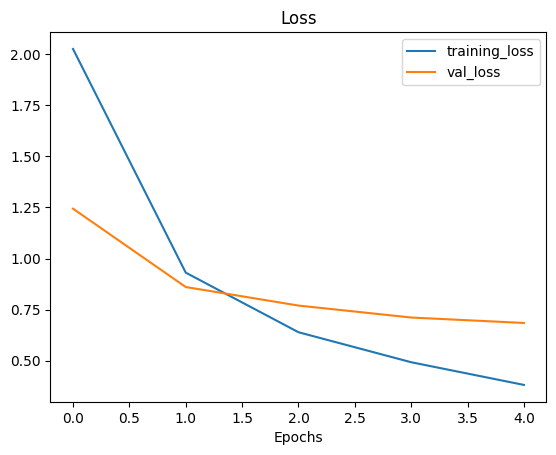

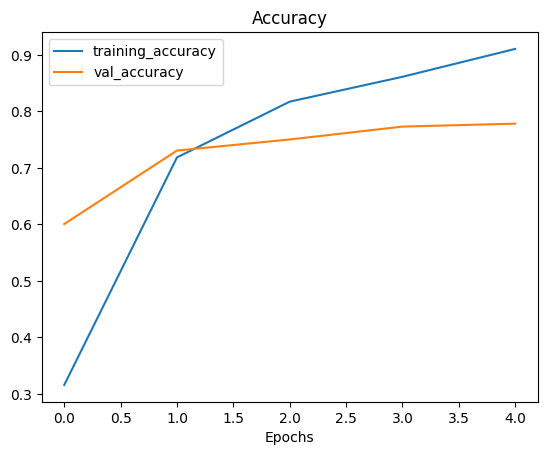

In [12]:
plot_loss_curves(resnet_history)

In [13]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
# Create model
efficientnet_model = create_model(
    model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
    num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(
    train_data_10_percent, # only use 10% of training data
    epochs=5, # train for 5 epochs
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback(
        dir_name="tensorflow_hub", 
        # Track logs under different experiment name
        experiment_name="efficientnetB0")])

2023-07-09 03:56:04.422486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [4]
	 [[{{node inputs}}]]
2023-07-09 03:56:04.422542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [4]
	 [[{{node inputs}}]]
2023-07-09 03:56:04.478064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [4]
	 [[{{node inputs}}]]
2023-07-09 03:56:04.478120: 

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20230709-035607
Epoch 1/5


2023-07-09 03:56:07.029649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,224,224,3]
	 [[{{node inputs}}]]
2023-07-09 03:56:07.122146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,224,224,3]
	 [[{{node Placeholder}}]]
2023-07-09 03:56:07.179566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}

2023-07-09 03:56:07.693755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_5/block_3/se_expand_conv2d/StatefulPartitionedCall_grad/stack_5/block_3/se_expand_conv2d/StatefulPartitionedCall' with dtype float and shape [?,?,?,48]
	 [[{{node gradients/stack_5/block_3/se_expand_conv2d/StatefulPartitionedCall_grad/stack_5/block_3/se_expand_conv2d/StatefulPartitionedCall}}]]
2023-07-09 03:56:07.702837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_5/block_3/se_reduce_activation/PartitionedCall_grad/stack_5/block_3/se_reduce_activation/PartitionedCall' with dtype float and shape [?,1,1,48]
	 

2023-07-09 03:56:07.902991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_5/block_2/expand_activation/PartitionedCall_grad/stack_5/block_2/expand_activation/PartitionedCall' with dtype float and shape [?,?,?,1152]
	 [[{{node gradients/stack_5/block_2/expand_activation/PartitionedCall_grad/stack_5/block_2/expand_activation/PartitionedCall}}]]
2023-07-09 03:56:07.903042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_5/block_2/expand_activation/PartitionedCall_grad/stack_5/block_2/expand_activation/PartitionedCall_1' with dtype float and shape [?,?,?,1152]
	 [[{{node gradients/stack_5/b

2023-07-09 03:56:08.115340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_5/block_0/se_expand_conv2d/StatefulPartitionedCall_grad/stack_5/block_0/se_expand_conv2d/StatefulPartitionedCall' with dtype float and shape [?,?,?,28]
	 [[{{node gradients/stack_5/block_0/se_expand_conv2d/StatefulPartitionedCall_grad/stack_5/block_0/se_expand_conv2d/StatefulPartitionedCall}}]]
2023-07-09 03:56:08.125420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_5/block_0/se_reduce_activation/PartitionedCall_grad/stack_5/block_0/se_reduce_activation/PartitionedCall' with dtype float and shape [?,1,1,28]
	 

2023-07-09 03:56:08.320480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_4/block_2/depthwise_conv2d/StatefulPartitionedCall_grad/stack_4/block_2/depthwise_conv2d/StatefulPartitionedCall' with dtype float and shape [?,?,?,672]
	 [[{{node gradients/stack_4/block_2/depthwise_conv2d/StatefulPartitionedCall_grad/stack_4/block_2/depthwise_conv2d/StatefulPartitionedCall}}]]
2023-07-09 03:56:08.329528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_4/block_2/expand_activation/PartitionedCall_grad/stack_4/block_2/expand_activation/PartitionedCall' with dtype float and shape [?,?,?,672]
	 [[{{

2023-07-09 03:56:08.529057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_4/block_0/se_expand_conv2d/StatefulPartitionedCall_grad/stack_4/block_0/se_expand_conv2d/StatefulPartitionedCall' with dtype float and shape [?,?,?,20]
	 [[{{node gradients/stack_4/block_0/se_expand_conv2d/StatefulPartitionedCall_grad/stack_4/block_0/se_expand_conv2d/StatefulPartitionedCall}}]]
2023-07-09 03:56:08.537911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_4/block_0/se_reduce_activation/PartitionedCall_grad/stack_4/block_0/se_reduce_activation/PartitionedCall' with dtype float and shape [?,1,1,20]
	 

2023-07-09 03:56:08.734576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_3/block_2/expand_activation/PartitionedCall_grad/stack_3/block_2/expand_activation/PartitionedCall' with dtype float and shape [?,?,?,480]
	 [[{{node gradients/stack_3/block_2/expand_activation/PartitionedCall_grad/stack_3/block_2/expand_activation/PartitionedCall}}]]
2023-07-09 03:56:08.734618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_3/block_2/expand_activation/PartitionedCall_grad/stack_3/block_2/expand_activation/PartitionedCall_1' with dtype float and shape [?,?,?,480]
	 [[{{node gradients/stack_3/blo

2023-07-09 03:56:08.936735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_3/block_0/se_reduce_activation/PartitionedCall_grad/stack_3/block_0/se_reduce_activation/PartitionedCall' with dtype float and shape [?,1,1,10]
	 [[{{node gradients/stack_3/block_0/se_reduce_activation/PartitionedCall_grad/stack_3/block_0/se_reduce_activation/PartitionedCall}}]]
2023-07-09 03:56:08.936786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_3/block_0/se_reduce_activation/PartitionedCall_grad/stack_3/block_0/se_reduce_activation/PartitionedCall_1' with dtype float and shape [?,1,1,10]
	 [[{{node gradi

2023-07-09 03:56:09.138584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_2/block_1/expand_activation/PartitionedCall_grad/stack_2/block_1/expand_activation/PartitionedCall' with dtype float and shape [?,?,?,240]
	 [[{{node gradients/stack_2/block_1/expand_activation/PartitionedCall_grad/stack_2/block_1/expand_activation/PartitionedCall}}]]
2023-07-09 03:56:09.138633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_2/block_1/expand_activation/PartitionedCall_grad/stack_2/block_1/expand_activation/PartitionedCall_1' with dtype float and shape [?,?,?,240]
	 [[{{node gradients/stack_2/blo

2023-07-09 03:56:09.348013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_1/block_1/se_reduce_activation/PartitionedCall_grad/stack_1/block_1/se_reduce_activation/PartitionedCall' with dtype float and shape [?,1,1,6]
	 [[{{node gradients/stack_1/block_1/se_reduce_activation/PartitionedCall_grad/stack_1/block_1/se_reduce_activation/PartitionedCall}}]]
2023-07-09 03:56:09.348055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_1/block_1/se_reduce_activation/PartitionedCall_grad/stack_1/block_1/se_reduce_activation/PartitionedCall_1' with dtype float and shape [?,1,1,6]
	 [[{{node gradien

2023-07-09 03:56:09.551405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_1/block_0/expand_conv2d/StatefulPartitionedCall_grad/stack_1/block_0/expand_conv2d/StatefulPartitionedCall' with dtype float and shape [?,?,?,16]
	 [[{{node gradients/stack_1/block_0/expand_conv2d/StatefulPartitionedCall_grad/stack_1/block_0/expand_conv2d/StatefulPartitionedCall}}]]
2023-07-09 03:56:09.571152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/stack_0/block_0/project_conv2d/StatefulPartitionedCall_grad/stack_0/block_0/project_conv2d/StatefulPartitionedCall' with dtype float and shape [?,?,?,32]
	 [[{{node

2023-07-09 03:56:10.069388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,?,?,?]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-07-09 03:56:10.069443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1' with dtype int32 and shape [2]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1}}]]
2023-07-09 03:56:10.069476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor s

2023-07-09 03:56:10.364479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,?,?,?]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-07-09 03:56:10.364540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1' with dtype int32 and shape [2]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1}}]]
2023-07-09 03:56:10.364577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor s

24/24 [==============================] - ETA: 0s - loss: 1.8957 - accuracy: 0.4080

2023-07-09 03:56:19.188405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - 38s 1s/step - loss: 1.8957 - accuracy: 0.4080 - val_loss: 1.3353 - val_accuracy: 0.7088
Epoch 2/5
24/24 [==============================] - 33s 1s/step - loss: 1.0895 - accuracy: 0.7627 - val_loss: 0.8876 - val_accuracy: 0.8176
Epoch 3/5
24/24 [==============================] - 33s 1s/step - loss: 0.7719 - accuracy: 0.8240 - val_loss: 0.7104 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 34s 1s/step - loss: 0.6194 - accuracy: 0.8707 - val_loss: 0.6195 - val_accuracy: 0.8476
Epoch 5/5
24/24 [==============================] - 34s 1s/step - loss: 0.5202 - accuracy: 0.8920 - val_loss: 0.5630 - val_accuracy: 0.8620


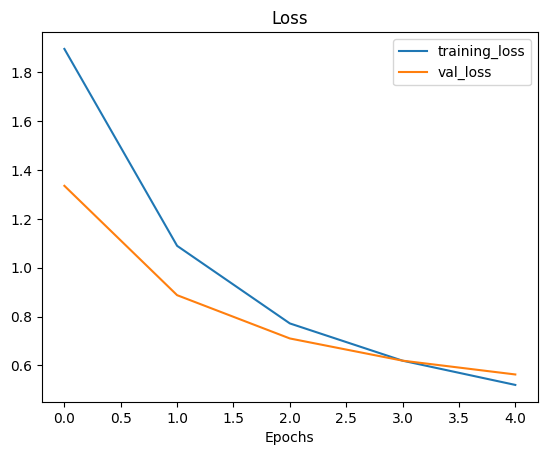

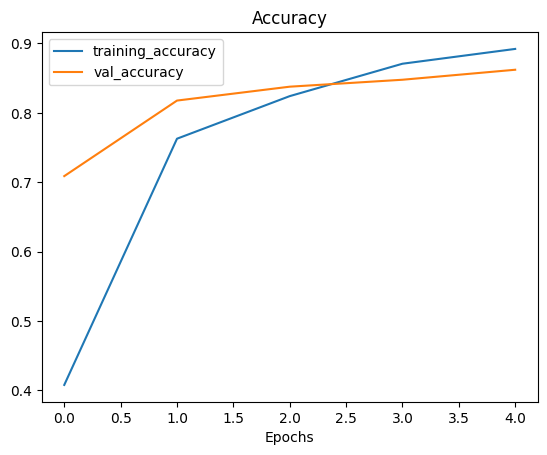

In [15]:
plot_loss_curves(efficientnet_history)

In [16]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


### Comparing models using TensorBoard

In [20]:
!tensorboard dev upload --logdir ./tensorflow_hub --name "EfficientNetB0 vs. ResNet50V2" --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" --one_shot

2023-07-09 04:08:11.984755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-09 04:08:12.627509: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/vaWq857kRVaBOk9NpqZ5tQ/

[2023-07-09T04:08:13] Started scanning logdir.
[2023-07-09T04:08:17] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.7 MB)
[2023-07-09T04:08:17] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/vaWq857kRVaBOk9NpqZ5tQ/


In [21]:
!tensorboard dev list

2023-07-09 04:08:26.172118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-09 04:08:26.952997: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
https://tensorboard.dev/experiment/vaWq857kRVaBOk9NpqZ5tQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   vaWq857kRVaBOk9NpqZ5tQ
	Created              2023-07-09 04:08:13 (15 seconds ago)
	Updated              2023-07-09 04:08:17 (11 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes

In [22]:
!tensorboard dev delete --experiment_id PyG6lkNxSDyGDSWpFDvP6Q

2023-07-09 04:08:41.208954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-09 04:08:41.884833: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
No such experiment PyG6lkNxSDyGDSWpFDvP6Q. Either it never existed or it has already been deleted.

